<a href="https://colab.research.google.com/github/yosephhabtu/MC-CMSC-206-Group-Project/blob/main/CMSC_206_Group_Project_NBA_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Selected dataset

In [ ]:
import pandas as pd
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')
nba_shots_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

## Shivom


### Question: Is there a linear relationship between time since drafted and average points?


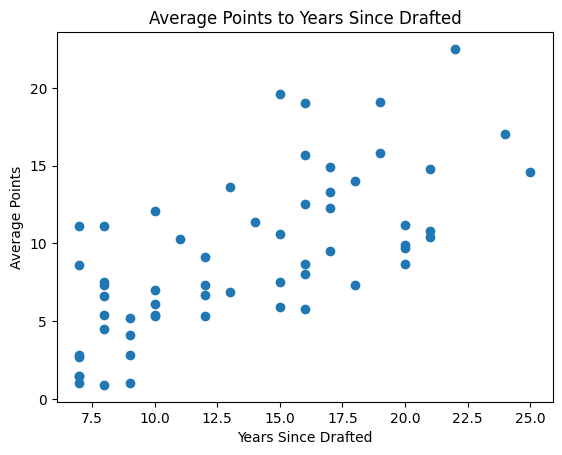

In [ ]:
# Author: Shivom Pandey
!pip install nba_api
from nba_api.stats.static import players
from nba_api.stats.endpoints import cumestatsplayer
from nba_api.stats.endpoints import commonplayerinfo

import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt


def calcAPI(name):

  # If player in both collections
  if name in playerdf['full_name'].values:

    # Get the corresponding player ID to retrieve stats
    id = playerdf.loc[playerdf['full_name'] == name, 'id'].iloc[0]
    time.sleep(0.6) # Wait half a second so the API doesn't block requests
    try:
      stats = commonplayerinfo.CommonPlayerInfo(player_id=str(id)).get_data_frames()[1]

      # If the stats are for the entire career of the player
      if stats['TimeFrame'][0] == 'career':
        return stats['PTS']
    except:
      print("Accessing API too fast")

  return -1

# Get all players from API
allPlayers = players.get_players()
playerdf = pd.DataFrame(allPlayers)

#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#vvvvv ACCESSING BALLDONTLIE API vvvvv

# Initial setup for while loop to go through entire API
cursor = 100
url = 'https://api.balldontlie.io/v1/players?per_page=25' # Set per_page to 25 if doing a short run without looping and 100 for a full run
headers = {
    'Authorization': 'c7f2362f-0e49-4910-80f4-1c5176b5d272'
}

response = requests.get(url, headers=headers)
if response.status_code == 200:
  dataJson = response.json()
else:
  print("Error:", response.status_code)

refinedData = pd.DataFrame(dataJson["data"])


# Loop to process through all pages of the API
counter = 0 # API limits to 30 requests/min, so the counter keeps track of requests
while cursor != -1:
  # url is adjusted for the next set of values
  url = 'https://api.balldontlie.io/v1/players?' + '&cursor=' + str(cursor) + '&per_page=100'
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
    # Access the data and add it to the existing dataframe
    dataJson = response.json()
    tempData = pd.DataFrame(dataJson["data"])
    refinedData = pd.concat([refinedData, tempData])

    # As long as the json keeps giving next cursors, keep looping
    try:
      nextCursor = dataJson['meta']['next_cursor']
      cursor = int(nextCursor)
      counter += 1
    except:
      cursor = -1

  else:
    print("Error:", response.status_code)

  # Every 29 requests, the code will pause for a minute to reset the API limits
  #if counter % 29 == 0:
  #  time.sleep(60)

  # Terminate after 1 example round to save run time :
  if counter == 1:
    cursor = -1

#^^^^^ DONE WITH BALLDONTLIE API ^^^^^
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Drop unnecessary columns from the data and rows missing data
refinedData.drop(["college", "draft_round", "team", 'position', 'height', 'weight', 'jersey_number', 'country'], axis = 1, inplace = True)
refinedData.dropna(subset = ['draft_year'], inplace=True)

# Add necessary data columns
refinedData['full_name'] = refinedData['first_name'] + " " + refinedData['last_name']
refinedData['years'] = refinedData['draft_year'].apply(lambda x: 2025.0 - x)

# Get the average points of the players from the other API and filter out invalid results (all the -1's)
refinedData['AVG_PT'] = refinedData.apply(lambda x: calcAPI(x['full_name']), axis=1)
refinedData = refinedData[refinedData['AVG_PT'] > 0]

plt.scatter(x=refinedData['years'], y=refinedData['AVG_PT'])
plt.xlabel("Years Since Drafted")
plt.ylabel("Average Points")
plt.title("Average Points to Years Since Drafted")
plt.show()
print()

From this scatter plot, it can be determined that there is a rough linear coorelation between the years since a player has been drafted and their average points. The outliers from this data could be players that didn't improve, were quickly removed from the league, or played in a different era where their improvement is 'less noticeable' compared to more recent players.

### Question: Which players have the furthest successful, unsuccessful, and overall shot distances in the 2014-15 season?


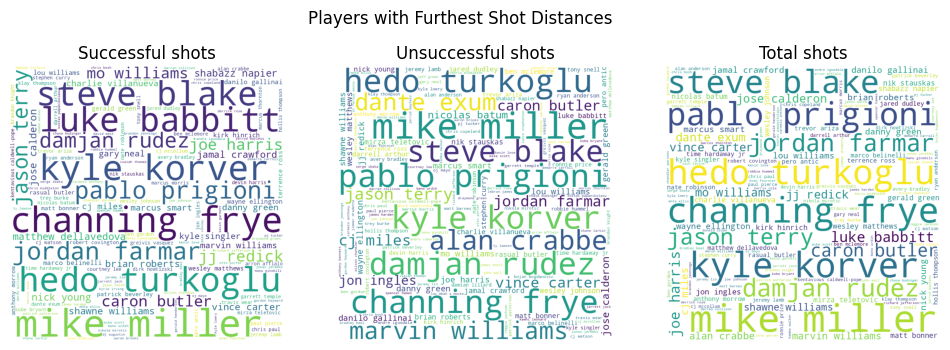

In [ ]:
# Author: Shivom Pandey
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')

# Set up multiple plots and set titles for all word clouds
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (12, 4))
fig.suptitle('Players with Furthest Shot Distances')
ax1.set_axis_off()
ax1.set_title('Successful shots')
ax2.set_axis_off()
ax2.set_title('Unsuccessful shots')
ax3.set_axis_off()
ax3.set_title('Total shots')

# Filter data to relevant columns
total = nba_shots_data[['player_name', 'SHOT_RESULT', 'SHOT_DIST']].copy()
successData = total[total['SHOT_RESULT'] == 'made']
unsuccessData = total[total['SHOT_RESULT'] == 'missed']

# Successful word cloud
playerDistances = successData.groupby('player_name')['SHOT_DIST'].mean()
pdDict = playerDistances.to_dict()
successCloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(pdDict)
ax1.imshow(successCloud)

# Unsuccessful word cloud
playerDistances = unsuccessData.groupby('player_name')['SHOT_DIST'].mean()
pdDict = playerDistances.to_dict()
unsuccessCloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(pdDict)
ax2.imshow(unsuccessCloud)

# Total word cloud
playerDistances = total.groupby('player_name')['SHOT_DIST'].mean()
pdDict = playerDistances.to_dict()
totalCloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(pdDict)
ax3.imshow(totalCloud)

From these word clouds, it can be seen that the top furthest successful shooters are Mike Miller, Channing Frye, Hedo Turkoglu, Steve Blake, and Kyle Korver. With some overlap, Mike Miller, Kyle Korver, Channing Frye, Steve Blake, and Hedo Turkoglu all are top furthest shot missers. In the mix of top unsuccessful shooters are also Pablo Prigioni, Alan Crabbe, and Damjan Rudez.

In total, the furthest shooters are Mike Miller and Kyle Korver, followed by (in no particular order) Channing Frye, Pablo Prigioni, Hedo Turkoglu, and Steve Blake.

### Question: What is the relationship between elapsed game time and points scored in the 2014-15 season?


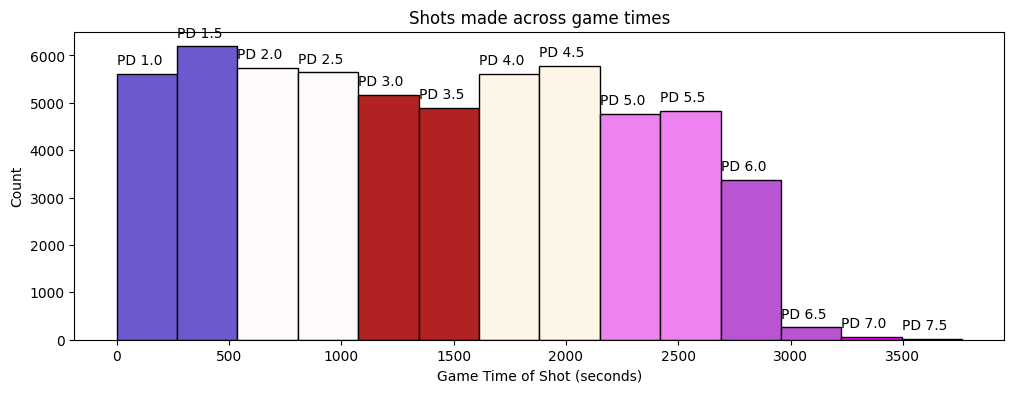

In [ ]:
# Author: Shivom Pandey
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')

# Function to turn mm:ss and game period into ss number
def secondify(time, period):
    minutes, seconds = map(int, time.split(':'))

    # Periods are 12 minutes till 4th period, and then 5 minutes each
    if period < 5:
      return (minutes*60+seconds) + (12*60*(period - 1))
    else:
      return (minutes*60+seconds) + (12*60*(4)) + (5*60*(period-5))

# Filter data to relevant columns
refinedData = nba_shots_data[['GAME_CLOCK', 'SHOT_RESULT', 'PERIOD']].copy()

# Turn made/missed shot results into boolean form
refinedData.loc[refinedData['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = True
refinedData.loc[refinedData['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = False

# Call the .apply() with a lambda to turn the string text into second format
refinedData['GAME_CLOCK'] = refinedData.apply(lambda x: secondify(x['GAME_CLOCK'], x['PERIOD']), axis = 1)

# Filter shots to only shots that were made
finalData = refinedData.loc[refinedData['SHOT_RESULT'] == True, 'GAME_CLOCK']
colors = ['slateblue', 'slateblue', 'snow', 'snow', 'firebrick', 'firebrick', 'oldlace', 'oldlace', 'violet', 'violet', 'mediumorchid', 'mediumorchid',  'magenta', 'magenta']
counts, bins = np.histogram(finalData, bins=14)

# Add labels and title
fig, ax1 = plt.subplots(figsize = (12, 4))
ax1.set_xlabel("Game Time of Shot (seconds)")
ax1.set_ylabel("Count")
ax1.set_title("Shots made across game times")

# Plot bars manually
for i in range(len(counts)):
  ax1.bar(x=bins[i], height=counts[i], width=bins[i+1] - bins[i], color=colors[i], edgecolor='black', align='edge')
  ax1.text(x=bins[i] ,y=counts[i]+200, s="PD " + str(1+ i/2), ha='left')

fig.show()
print()

From this histogram, it can be determined that the amount of shots made fluctuates with game time. It peaks at the second half of the first period (players are starting the games strong), slowly decreasing until the fourth period. At the first half of the fourth period, the count spikes, increasing in the second half as players (desparately?) shoot for more points. After the fourth period, most games end, but some go into 5-minute overtimes, which show an exponential decrease due to the increasing improbability that a game will need another overtime.

## David L.

Question 1: How does game location (Home vs. Away) affect shooting percentages at different shot distances?

<ipython-input-3-42b34bec634e>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = nba_shots_data.groupby(['LOCATION', 'SHOT_RANGE'])['SHOT_MADE'].mean() * 100


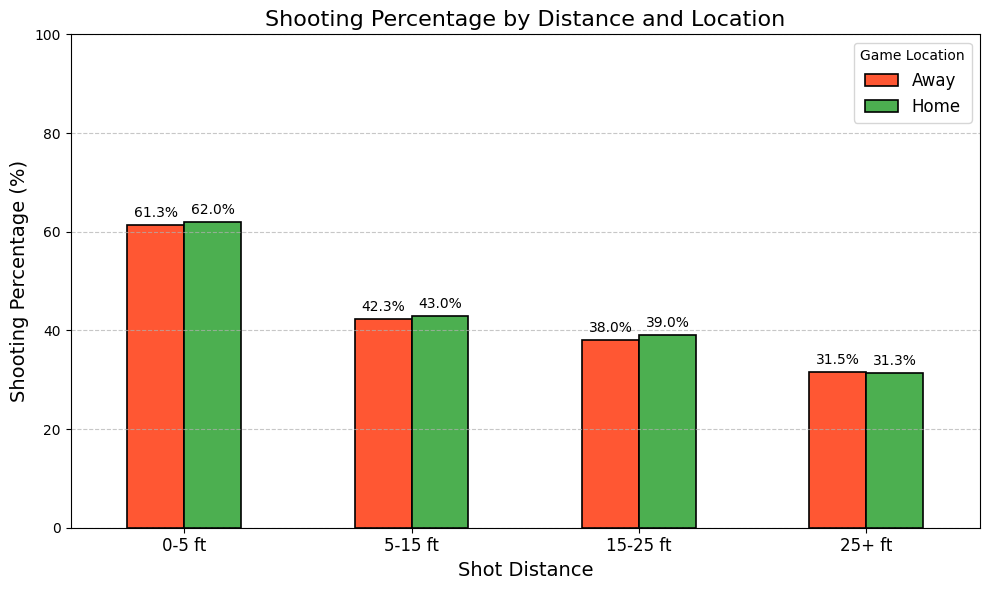

In [ ]:
#David Liv
import pandas as pd
import matplotlib.pyplot as plt

nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')

nba_shots_data['SHOT_MADE'] = nba_shots_data['SHOT_RESULT'].apply(lambda x: 1 if x == 'made' else 0)

# Create bins for shot distances and label them
bins = [0, 5, 15, 25, 40]  # Ranges in feet
labels = ['0-5 ft', '5-15 ft', '15-25 ft', '25+ ft']
nba_shots_data['SHOT_RANGE'] = pd.cut(nba_shots_data['SHOT_DIST'], bins=bins, labels=labels)

# Group the data by location and shot range
grouped_data = nba_shots_data.groupby(['LOCATION', 'SHOT_RANGE'])['SHOT_MADE'].mean() * 100


pivot_data = grouped_data.unstack(level=0)

ax = pivot_data.plot(kind='bar', figsize=(10, 6), color=['#FF5733', '#4CAF50'], edgecolor='black', linewidth=1.2)


for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:  # Avoid labels on empty bars
            ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=10)

plt.title('Shooting Percentage by Distance and Location', fontsize=16)
plt.xlabel('Shot Distance', fontsize=14)
plt.ylabel('Shooting Percentage (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.ylim(0, 100)
plt.legend(['Away', 'Home'], title='Game Location', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Question 2: What are the top 10 players' most accurate shooting spots based on shot distance, and what are their shooting percentages at these spots?

<ipython-input-4-f69da1667caf>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_shooting = nba_shots_data.groupby([player_column, 'SHOT_RANGE'])['SHOT_MADE'].mean() * 100


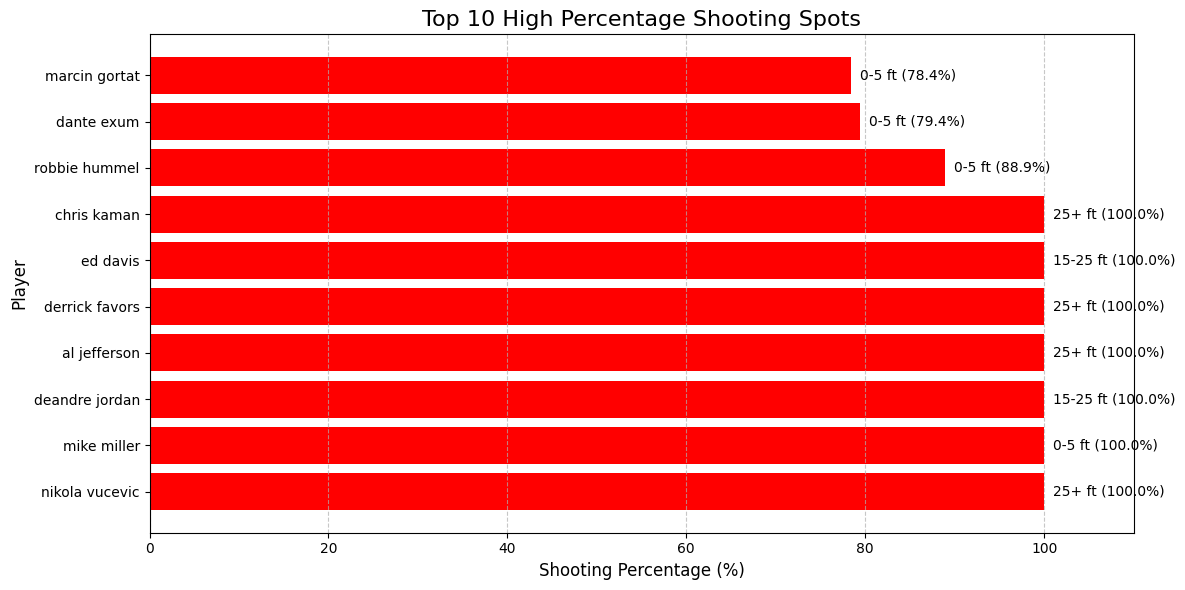

In [ ]:
#David Liv
import pandas as pd
import matplotlib.pyplot as plt


nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')


nba_shots_data['SHOT_MADE'] = nba_shots_data['SHOT_RESULT'].apply(lambda x: 1 if x == 'made' else 0)


bins = [0, 5, 15, 25, 40]  # Ranges in feet
labels = ['0-5 ft', '5-15 ft', '15-25 ft', '25+ ft']
nba_shots_data['SHOT_RANGE'] = pd.cut(nba_shots_data['SHOT_DIST'], bins=bins, labels=labels)


player_column = 'player_name'

# Group by player and shot range to calculate shooting percentages
player_shooting = nba_shots_data.groupby([player_column, 'SHOT_RANGE'])['SHOT_MADE'].mean() * 100

# range with the highest percentage for each player
high_percentage_spots = player_shooting.groupby(player_column).idxmax()


high_percentage_values = player_shooting.groupby(player_column).max()

# Combine results into a DataFrame
high_percentage_df = pd.DataFrame({
    'High Percentage Spot': [spot[1] for spot in high_percentage_spots],
    'Shooting Percentage': high_percentage_values
}).reset_index()

# Select the top 10 players with the highest shooting percentages
top_10_df = high_percentage_df.sort_values(by='Shooting Percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_10_df[player_column], top_10_df['Shooting Percentage'], color='red')

# Annotate the ranges on the bars
for bar, spot, percentage in zip(bars, top_10_df['High Percentage Spot'], top_10_df['Shooting Percentage']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f"{spot} ({percentage:.1f}%)", va='center', fontsize=10)

plt.xlabel('Shooting Percentage (%)', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.title('Top 10 High Percentage Shooting Spots', fontsize=16)
plt.xlim(0, 110)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Question 3: Do players shoot more accurately when defended closely or with more space between them and the defender?

<ipython-input-5-0a3549012e0d>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  defense_shooting = nba_shots_data.groupby('DEF_DIST_RANGE')['SHOT_MADE'].mean() * 100


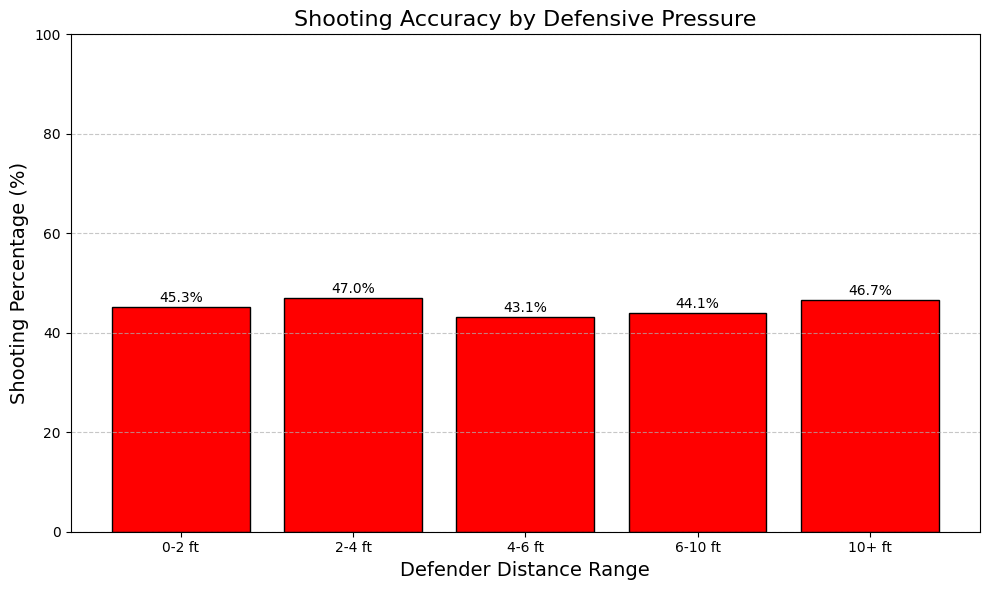

In [ ]:
#David Liv
import pandas as pd
import matplotlib.pyplot as plt

nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')

nba_shots_data['SHOT_MADE'] = nba_shots_data['SHOT_RESULT'].apply(lambda x: 1 if x == 'made' else 0)

def_dist_bins = [0, 2, 4, 6, 10, 20]  # Ranges
def_dist_labels = ['0-2 ft', '2-4 ft', '4-6 ft', '6-10 ft', '10+ ft']
nba_shots_data['DEF_DIST_RANGE'] = pd.cut(nba_shots_data['CLOSE_DEF_DIST'], bins=def_dist_bins, labels=def_dist_labels)

# Group by defender distance range and calculate shooting percentages
defense_shooting = nba_shots_data.groupby('DEF_DIST_RANGE')['SHOT_MADE'].mean() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(defense_shooting.index, defense_shooting, color='red', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.title('Shooting Accuracy by Defensive Pressure', fontsize=16)
plt.xlabel('Defender Distance Range', fontsize=14)
plt.ylabel('Shooting Percentage (%)', fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Yaseen

###Question 1: What Percentage of Games Are Won At Home, and What Percentage of Games Are Won Away?

Data of games won at home, and away from home:
LOCATION
H    35956
A    28639
Name: count, dtype: int64


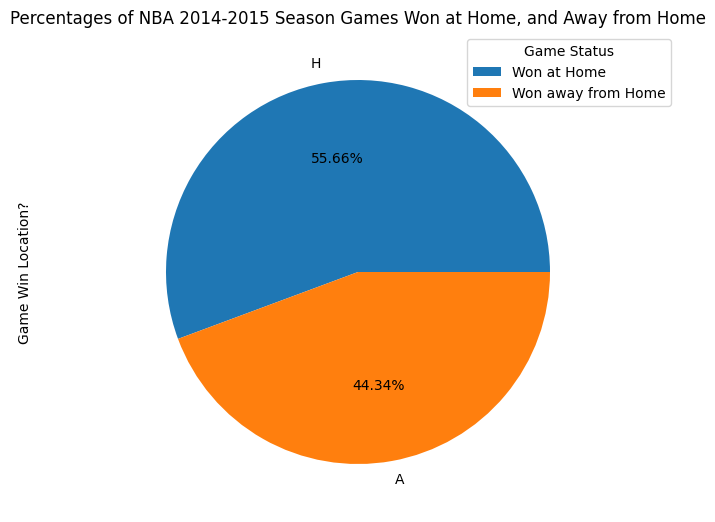

In [ ]:
#The next following 3 questions were coded and written by Yaseen Hajiabbasi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Loads in the dataset, and filters it to the game Id, location, as well as if it was a win or a lose. Furthermore, it also gets rid of duplicate rows, so as to look at a game by game basis
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')
games = nba_shots_data[['GAME_ID', 'LOCATION', 'W']]
notGames = games.drop_duplicates(inplace = False)

#Grabs the total amount of games, grabs all of the games that were won, and takes in the counts of the locations
wonGames = games[games['W']== 'W']
totalGames, _ = wonGames.shape
counters = wonGames.value_counts('LOCATION')

#Calculates the percentages, and graphs the pie chart
percents = [((counters.max()/totalGames) * 100),((counters.min()/totalGames) * 100)]
names = ['Won at Home', 'Won away from Home']

figures = plt.figure()
axis = figures.add_axes([0,0,1,1])
axis.axis('equal')
axis.pie(percents, labels = ['H', 'A'], autopct = '%1.2f%%')
plt.title('Percentages of NBA 2014-2015 Season Games Won at Home, and Away from Home')
print(f'Data of games won at home, and away from home:\n{counters}')
plt.legend(names, title='Game Status', loc = 'upper right')
plt.ylabel('Game Win Location?')
plt.show()

Overall, the evidence and statistics show that out of games won, teams that play at home have a higher win rate than teams that play at an away location. This can be seen as out of won games in the NBA 2014-2015 season, 55.66% of them were done at the home location, while 44.34% were won at the away location.

### Question 2: Who Are The Players With the Highest Average Shot Clock Time Per Shot in the 2014-2015 NBA Season?

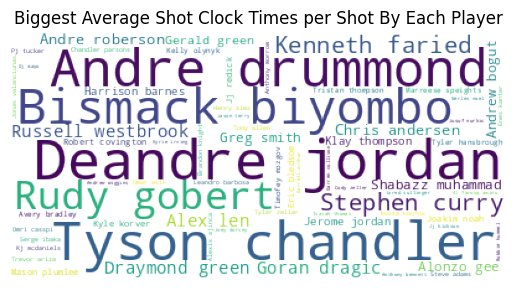

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

#Loads in the dataset, the filters it by the numbers of each players shot, the shot clock time for each separate shot, as well as the player names
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')
trend2data = nba_shots_data[['SHOT_NUMBER', 'SHOT_CLOCK' ,'player_name']]

#creates the lists, and dictionary to be used in the processing and plotting
playerList = []
dataSet = []
frequencies = dict()

#Creates the list of players processed, calculates the amount of shots each player took, and their total shot clock time, and put it into frequencies
for player in trend2data['player_name']:
  if player not in playerList:
    shots = 0
    clock = 0.0
    playerList.append(player)
    playerData = trend2data[trend2data['player_name']==player]
    playerData = playerData.fillna(0)
    for value in playerData['SHOT_NUMBER']:
      shots += 1
    for value in playerData['SHOT_CLOCK']:
      clock += value
    frequencies[f'{player.capitalize()}'] = round(clock/shots, 3)

#generates the word cloud from the frequencies, with players that have a larger name being ones that have a higher average shot clock time per shot
wd = WordCloud(prefer_horizontal=0.9,background_color='rgba(255, 255, 255, 0)', mode='RGBA').generate_from_frequencies(frequencies)
plt.imshow(wd)
plt.axis('off')
plt.title('Biggest Average Shot Clock Times per Shot By Each Player')
plt.show()
wd.to_file('cloud.png');

Overall, the evidence and statistics show that out of all of the players, the top 5 players who have the highest average shot clock times per shot are Deandre Jordan, Tyson Chandler, Bismack Biyombo, Andre Drummond, and Rudy Gobert. This can be seen as they show up the largest on the word cloud.

### Question 3: Has a Team Who Has Played in the Present Season of NBA so far Improved Their Win Rate over time vs. Their Win Rate in the 2014-2015 Season?

  Using cached nba_api-1.6.1-py3-none-any.whl.metadata (5.5 kB)
Using cached nba_api-1.6.1-py3-none-any.whl (279 kB)


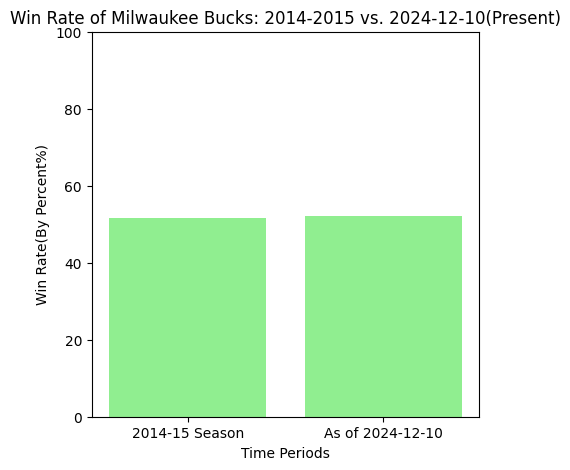

In [ ]:
#grabs the api
!pip install nba_api
from nba_api.live.nba.endpoints import scoreboard
import pandas as pd
import matplotlib.pyplot as plt
count = 0
wins = 0

#Loads up the 2014-2015 dataset, and filters it by game id, location, win status, and matchup, as well as removes duplicates to look at a game by game basis
nba = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')
gamesr = nba[['GAME_ID', 'LOCATION', 'W', 'MATCHUP']]
notGames = gamesr.drop_duplicates(inplace = False)

#Grabs the most recent data from the api and turns it into a json and a dictionary to be processed
games = scoreboard.ScoreBoard()
games_json = games.get_json()
twentySix = dict()
games_dict = games.get_dict()

#grabs the games data, as well as the date of the api's live data
records = games_dict['scoreboard']['games']
date = games_dict['scoreboard']['gameDate']

#generates a new dictionary based off of the api's live data, and creates a pandas dataframe based off of it
twentySix['GAME_IDS'] = [game['gameId'] for game in records]
for key in ['home', 'away']:
  twentySix[f'{key}team'] = [f"{game[f'{key}Team']['teamCity']} {game[f'{key}Team']['teamName']}" for game in records]
  twentySix[f'{key}teamTricode'] = [game[f'{key}Team']['teamTricode'] for game in records]
  twentySix[f'{key} wins'] = [game[f'{key}Team']['wins'] for game in records]
  twentySix[f'{key} losses'] = [game[f'{key}Team']['losses'] for game in records]
data = pd.DataFrame(twentySix)

#Grabs the first team who is present in both datasets(present & 2014-2015)
for value in data['hometeamTricode']:
  for matchup in gamesr['MATCHUP']:
    if value in matchup:
      code = value
  break

#filters the 2014-2015 dataset for games that had that team in the matchup, and grabs their total amount of wins, and games played based off of what order in the matchup they were
newData = notGames[notGames['MATCHUP'].str.contains(code)]
for value in newData['MATCHUP']:
  if value.split()[4] == code:
    if newData.iloc[count]['W'] == 'W':
      wins += 1
  elif value.split()[6] == code:
    if newData.iloc[count]['W'] == 'L':
      wins += 1
  count += 1

# grabs the team name based off of the tricode, as well as their total amount of games in the 2014-2015 season
count = 0
for value in data['hometeamTricode']:
  if value == code:
    team = data.iloc[count]['hometeam']
  count += 1
totalGames, _ = newData.shape

#grabs their win rate in the present, as well as the 2014-2015 season, and creates a bar chart based off of it
newWins = data[data['hometeamTricode'] == code].iloc[0]['home wins']
newGames = newWins + data[data['hometeamTricode'] == code].iloc[0]['home losses']
winRate = [round((wins/totalGames)*100, 2), round((newWins/newGames)*100, 2)]
fig, ax = plt.subplots(figsize = (5,5))
ax.bar(['2014-15 Season', f'As of {date}'], winRate, color = 'lightgreen')
ax.set_ylim(0,100);
ax.set_title(f'Win Rate of {team}: 2014-2015 vs. {date}(Present)');
ax.set_xlabel('Time Periods');
ax.set_ylabel('Win Rate(By Percent%)');
plt.show()

In [ ]:
#generates an automated finding, due to the fact that the api live data updates daily
if winRate[0] > winRate[1]:
  winner = '2014-2015 NBA Season'
  loser = 'present day NBA season as of now'
  rate = winRate[0]
  lrate = winRate[1]
elif winRate[0] < winRate[1]:
  winner = 'present day NBA season as of now'
  loser = '2014-2015 NBA Season'
  rate = winRate[1]
  lrate = winRate[0]
print(f'As we can see, based off of the evidence and statistics, the {team} had a higher win rate during the {winner} \nwith a {rate}% win rate, as opposed to their time in the {loser}, with a {lrate}% win rate.')

As we can see, based off of the evidence and statistics, the Milwaukee Bucks had a higher win rate during the present day NBA season as of now 
with a 52.17% win rate, as opposed to their time in the 2014-2015 NBA Season, with a 51.67% win rate.


## Zachary

In [ ]:
#Must do this
!pip install nba_api==1.1.12
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.9/254.9 kB 3.9 MB/s eta 0:00:00


1. What is the most frequent scoring location?

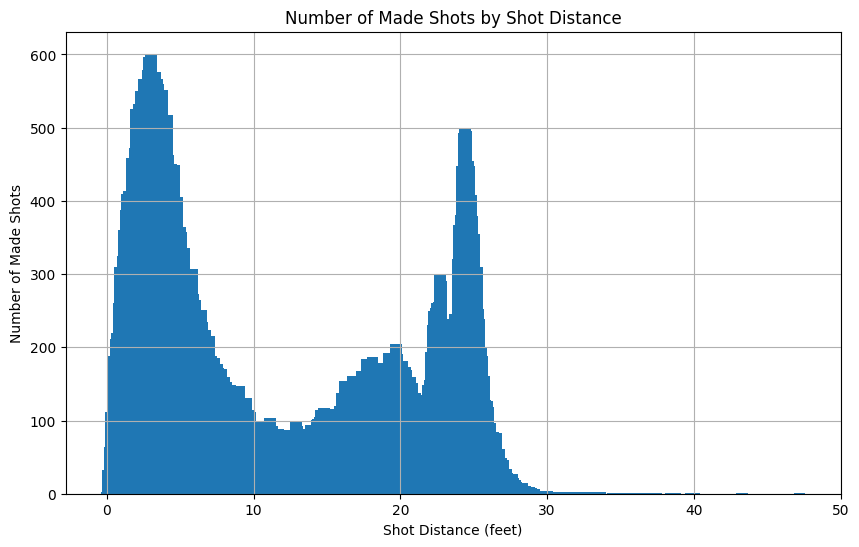

In [ ]:
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')
made_shots = nba_shots_data[nba_shots_data['SHOT_RESULT'] == "made"]
shots_by_distance = made_shots.groupby('SHOT_DIST').count()
plt.figure(figsize=(10, 6))
plt.bar(shots_by_distance.index, shots_by_distance['GAME_ID'])
plt.xlabel('Shot Distance (feet)')
plt.ylabel('Number of Made Shots')
plt.title('Number of Made Shots by Shot Distance')
plt.grid(True)
plt.show()

Conclusion: The graph is bimodal, meaning there are two really common locations of the made shots. The most common made shot distance seem to be around 5ft adn around 25 feet. This makes sense since shooting close is good, but so is shooting past the three point line, which is 22 feet for a nba standard court. Overall, the most common scoring locations are 5 feet and 25 feet.

2. Is there a relationship between height and most frequent scoring location?

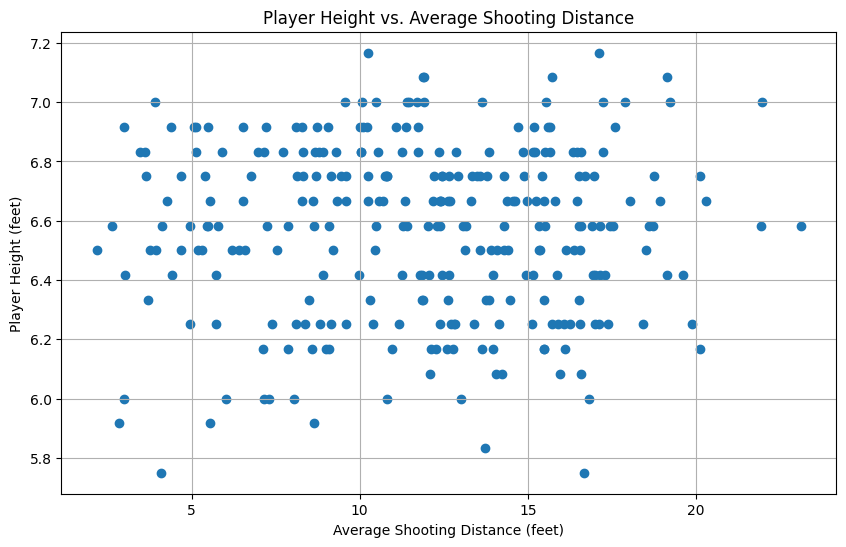

In [ ]:
#Use an api to get player height
#create a chart comparing player height to average shooting distance
#This does tend to take a minute as it is accessing a lot of data with a sleep of .5 seconds. It usually takes around 3-4 minutes, but it needs to have the sleep to avoid breaking the api.
made_shots = nba_shots_data[nba_shots_data['SHOT_RESULT'] == 'made']
shooting_dist_by_player =made_shots.groupby('player_id')['SHOT_DIST'].mean()
player_heights = []

player_ids = nba_shots_data['player_id'].unique()
for id in player_ids:
  player_info = commonplayerinfo.CommonPlayerInfo(player_id=id)
  height = player_info.get_dict()['resultSets'][0]['rowSet'][0][11]
  height = height.split("-")
  try:
    true_height = (int(height[0])+(int(height[1])/12))
  except:
    #this is the one exception as tyler hansbrough's height isn't in the api for some reason
    true_height = 6.75
  player_heights.append(true_height)
  time.sleep(.5)

plt.figure(figsize=(10, 6))
plt.scatter(shooting_dist_by_player, player_heights)
plt.xlabel("Average Shooting Distance (feet)")
plt.ylabel("Player Height (feet)")
plt.title("Player Height vs. Average Shooting Distance")
plt.grid(True)
plt.show()

Conclusion:
There does not seem to be a relationship between player height and average shooting distance. The correlation is little to none, meaning there isn't a relationship.

3. Which player shoots the most?


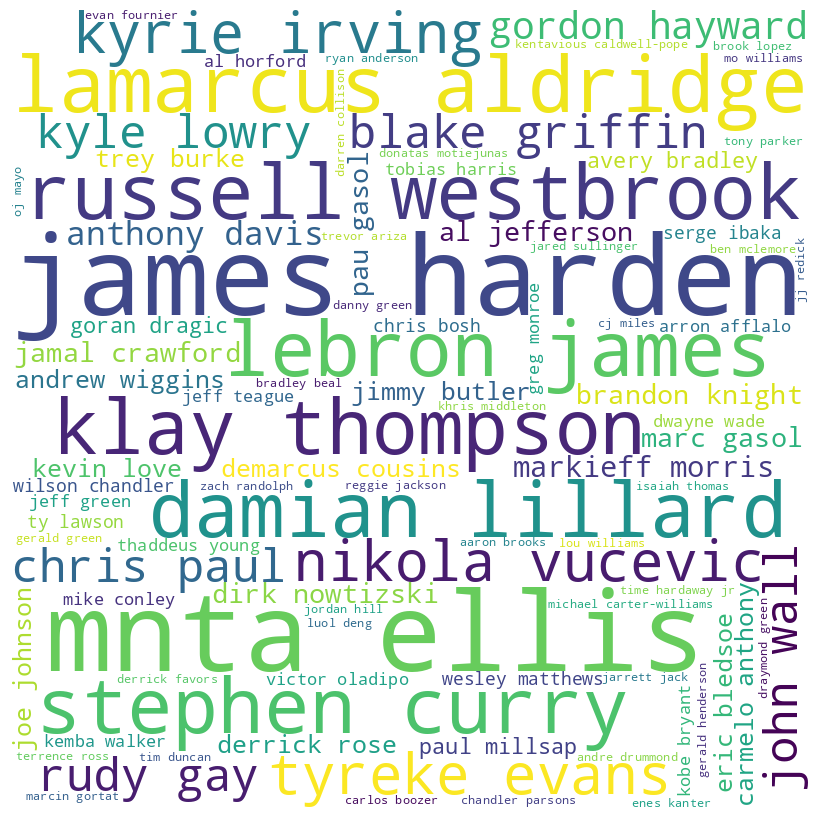

In [ ]:

player_shot_counts = nba_shots_data['player_name'].value_counts().to_dict()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(player_shot_counts)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Conclusion:
The players who take the most shots are Damian Lillaryd, James Harden, Stephen Curry, Mnta Ellis, Lamarcus Aldridge, Russell Westbrook, Lebron James, and Lkay Thompson

## Yoseph

In [ ]:
# Importing necessary libraries and loading data
import pandas as pd
import matplotlib.pyplot as plt
!pip install google
from googlesearch import search
import re
from wordcloud import WordCloud
nba_shots_data = pd.read_csv('https://github.com/yosephhabtu/MC-CMSC-206-Group-Project/raw/refs/heads/main/shot_logs.csv')

### Question 1: How is shooting efficiency affected by dribbling?

In [ ]:
# Calculating shot attempts, makes, and field goal percentages for catch-and-shoot and off-the-dribble shots across the league
catch_and_shoot =  nba_shots_data[nba_shots_data['DRIBBLES'] == 0]
off_the_dribble = nba_shots_data[nba_shots_data['DRIBBLES'] >= 1]

catch_and_shoot_makes = catch_and_shoot[catch_and_shoot['SHOT_RESULT'] == 'made']
catch_and_shoot_fgp = round((len(catch_and_shoot_makes) / len(catch_and_shoot)) * 100, 1)
off_the_dribble_makes = off_the_dribble[off_the_dribble['SHOT_RESULT'] == 'made']
off_the_dribble_fgp = round((len(off_the_dribble_makes) / len(off_the_dribble)) * 100, 1)

q1a = pd.DataFrame({'Shot Type':['Catch-and-Shoot', 'Off-the-Dribble'],
                   'Total Shots Attempted':[len(catch_and_shoot), len(off_the_dribble)],
                   'Total Shots Made':[len(catch_and_shoot_makes), len(off_the_dribble_makes)],
                   'Field Goal Percentage': [catch_and_shoot_fgp, off_the_dribble_fgp]})
print('Comparing League-Wide Field Goal Percentages between Catch-and-Shoot and Off-the-Dribble Shots\n*Catch-and-shoot = shots taken with 0 prior dribbles\n*Off-the-dribble = shots taken with at least one prior dribble\n')
q1a

Comparing League-Wide Field Goal Percentages between Catch-and-Shoot and Off-the-Dribble Shots
*Catch-and-shoot = shots taken with 0 prior dribbles
*Off-the-dribble = shots taken with at least one prior dribble



,Shot Type,Total Shots Attempted,Total Shots Made,Field Goal Percentage
0,Catch-and-Shoot,63195,29816,47.2
1,Off-the-Dribble,64874,28089,43.3


**Findings:**

In the 2014-2015 Regular Season, NBA players were more efficient at shooting off-the-catch than off-the-dribble, with a 4% higher field goal percentage on average. This makes sense because, generally speaking, players tend to take catch-and-shoot shots when they are relatively open and have good positioning, whereas they would often dribble the ball when facing more defensive pressure, likely leading to a more contested, off-balance shot.

  Number of Dribbles  Field Goal Percentage
0                  0                   47.2
1                1-2                   44.2
2                3-4                   42.8
3                 5+                   42.1




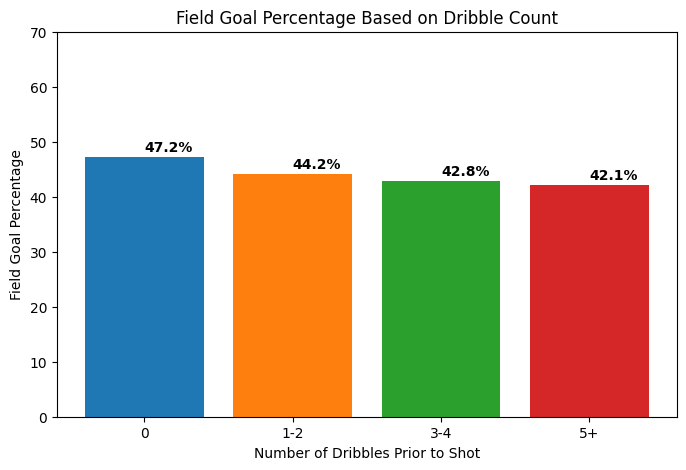

In [ ]:
# Grouping shots based on the number of prior dribbles and comparing their field goal percentages
dribbles_group1_fga = nba_shots_data[(nba_shots_data['DRIBBLES'] >= 1) & (nba_shots_data['DRIBBLES'] <=2)]
dribbles_group1_fgm = dribbles_group1_fga[dribbles_group1_fga['SHOT_RESULT'] == 'made']
dribbles_group1_fgp = (len(dribbles_group1_fgm) / len(dribbles_group1_fga)) * 100

dribbles_group2_fga = nba_shots_data[(nba_shots_data['DRIBBLES'] >= 3) & (nba_shots_data['DRIBBLES'] <= 4)]
dribbles_group2_fgm = dribbles_group2_fga[dribbles_group2_fga['SHOT_RESULT'] == 'made']
dribbles_group2_fgp = (len(dribbles_group2_fgm) / len(dribbles_group2_fga)) * 100

dribbles_group3_fga =  nba_shots_data[nba_shots_data['DRIBBLES'] >= 5]
dribbles_group3_fgm = dribbles_group3_fga[dribbles_group3_fga['SHOT_RESULT'] == 'made']
dribbles_group3_fgp = (len(dribbles_group3_fgm) / len(dribbles_group3_fga)) * 100

q1b = pd.DataFrame({'Number of Dribbles':['0', '1-2', '3-4', '5+'],
                     'Field Goal Percentage': [catch_and_shoot_fgp,
                                               dribbles_group1_fgp,
                                               dribbles_group2_fgp,
                                               dribbles_group3_fgp]})

q1b['Field Goal Percentage'] = q1b['Field Goal Percentage'].round(1)
print(q1b)
print('\n')

# Displaying a bar chart of the field goal percentages for each group of dribble counts
x = q1b['Number of Dribbles']
y = q1b['Field Goal Percentage']
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x, y, color=plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.set_xlabel('Number of Dribbles Prior to Shot')
ax.set_ylabel('Field Goal Percentage')
ax.set_title('Field Goal Percentage Based on Dribble Count')
ax.set_ylim(0, 70)
for group in q1b['Number of Dribbles']:
    percentage = q1b[q1b['Number of Dribbles'] == group].reset_index()['Field Goal Percentage'].loc[0]
    ax.text(x=group,
            y=percentage + 1,
            s=f'{percentage}%',
            weight='bold')
plt.show()

**Findings**

Further analysis shows that players generally shoot better when they minimize their dribbling, as seen in the bar chart above. Shots taken without dribbling (0 dribbles) have the highest field goal percentage at about 47%, and this value seems to decline as the number of dribbles increases, with shots after 5 or more dribbles being the least efficient at about 42%. This pattern suggests that teams should incorporate more motion offenses or drive-and-kick systems rather than isolation-based systems to create more catch-and-shoot opportunites, which will improve teams' overall shooting efficiency.

### Question 2: How does 3-point shooting impact team success?

In [ ]:
# Searching for websites to web scrape containing data on team stats
query = 'NBA 2014-2015 regular season team ratings'
results = []
for result in search(query, tld='co.in', num=5, stop=5, pause=2):
    results.append(result)
    print(result)

https://www.basketball-reference.com/leagues/NBA_2015_ratings.html
https://www.nba.com/standings?Season=2014-15
https://www.basketball-reference.com/leagues/NBA_2015.html
https://www.basketball-reference.com/leagues/NBA_2015_standings.html
https://www.basketball-reference.com/leagues/NBA_2016.html


3-Point Shot Data From the Top 5 Teams in Win Percentage:
   team       3P%   3PA  3PM   w/l%
9   GSW  0.399734  1501  600  0.817
0   ATL  0.386085  1466  566  0.732
26  SAS  0.367174  1182  434  0.671
14  MEM  0.342003   769  263  0.671
5   CLE  0.365434  1163  425  0.646

Correlation Coefficients:
- 3PM vs Win%: 0.68
- 3PA vs Win%: 0.61
- 3P% vs Win%: 0.58



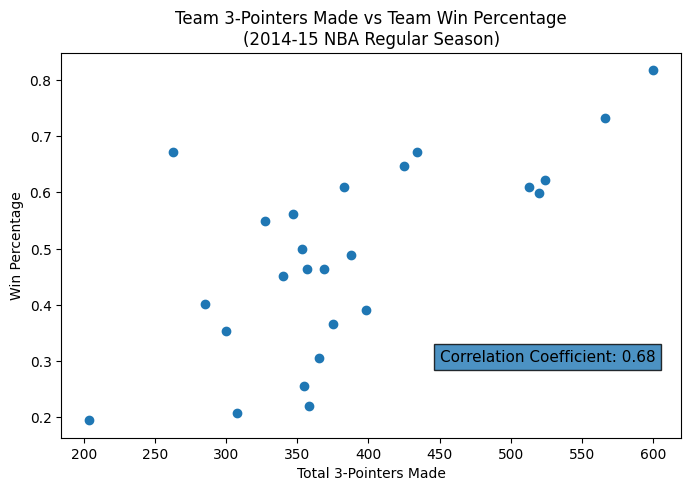

In [ ]:
# Scraping and loading the first data table from the first website listed in the Google search (contains win % data)
url = results[0]
team_stats = pd.read_html(url, header=None)[0]
team_stats.columns = team_stats.columns.droplevel(0).str.lower()

# Loading a text file containing team name abbrevations and their corresponding full names; this will make it easier to merge the scraped table with the original dataset
# Source of text file: https://gist.github.com/Tgemayel/e6e282b9aa538bb8b8b7
team_abbrev = pd.read_csv('https://gist.github.com/Tgemayel/e6e282b9aa538bb8b8b7/raw/f498ceeff06c995afc62ed8c89d634026f954d20/gistfile1.txt', sep='\t', header=None)
team_abbrev = team_abbrev.rename(columns={0:'abbrev', 1:'team'})
team_abbrev['abbrev'] = team_abbrev['abbrev'].str.replace('-', '')
team_abbrev['team'] = team_abbrev['team'].str.replace('-', '').str.strip()
team_abbrev.loc[29] = {'abbrev':'SAS', 'team':'San Antonio Spurs'} # added the San Antonia Spurs team because it was not included in the text file

# Merging the team stats data frame with the team abbreviations data frame to replace teams' full names with their abbreviations
team_stats = pd.merge(team_stats, team_abbrev, on='team')
team_stats = team_stats.drop('team', axis=1).rename(columns={'abbrev':'team'})
team_stats = team_stats[['team', 'w/l%']] # selecting only the team name and win% information

# Creating a new column in the original dataset to store the team name of the player who shot the ball by extracting it from the MATCHUP column
nba_shots_data['team'] = pd.Series([re.findall(r'[A-Z]{3}', matchup)[1] for matchup in nba_shots_data['MATCHUP']])

# Creating a data frame summarizing each team's total 3-point attempts, makes, and percentage
three_pointers_shot = nba_shots_data[nba_shots_data['PTS_TYPE'] == 3].groupby('team')[['GAME_ID']].count()
three_pointers_made = nba_shots_data[(nba_shots_data['PTS_TYPE'] == 3) & (nba_shots_data['SHOT_RESULT'] == 'made')].groupby('team')[['GAME_ID']].count()
three_point_pct = three_pointers_made / three_pointers_shot
three_point_pct.rename(columns={'GAME_ID': '3P%'}, inplace=True)
three_point_pct['3PA'] = three_pointers_shot
three_point_pct['3PM'] = three_pointers_made
three_point_pct.reset_index(inplace=True)

# Merging the team win% data frame with the three-pointers data frame
q2 = pd.merge(three_point_pct, team_stats, on='team', how='left')
q2.sort_values(by='w/l%', ascending=False, inplace=True)
print('3-Point Shot Data From the Top 5 Teams in Win Percentage:')
print(q2.head())

# Calculating and displaying the correlation coefficients between win% and each 3-point shooting metric
print(f'''\nCorrelation Coefficients:
- 3PM vs Win%: {round(q2[['3PM', 'w/l%']].corr().iloc[0, 1], 2)}
- 3PA vs Win%: {round(q2[['3PA', 'w/l%']].corr().iloc[0, 1], 2)}
- 3P% vs Win%: {round(q2[['3P%', 'w/l%']].corr().iloc[0, 1], 2)}\n''')

# Creating a scatterplot of 3-pointers made vs win%
x = q2['3PM']
y = q2['w/l%']
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y)

ax.set_xlabel('Total 3-Pointers Made')
ax.set_ylabel('Win Percentage')
ax.set_title('Team 3-Pointers Made vs Team Win Percentage\n(2014-15 NBA Regular Season)')
ax.text(x=450,
        y=0.3,
        s=f"Correlation Coefficient: {round(q2[['3PM', 'w/l%']].corr().iloc[0, 1], 2)}",
        bbox=dict(facecolor='#1f77b4', alpha=0.8),
        size=11)
plt.show()

**Findings:**

The data shows a moderate to strong postive correlation (0.68) between the number of 3-pointers made by a team and their win percentage in the 2014-2015 NBA regular season, suggesting that teams with higher 3-point production tend to perform better. While this relationship is the strongest, there are also moderate correlations with 3-point attempts (0.61) and 3-point percentage (0.58). The nature of these relationships indicates that both the shooting volume and efficiency of 3-pointers contribute to team success, which continues to be a notable theme in the NBA today.

### Question 3: Who were the best clutch peformers (by total points) during the 2014-2015 regular season?

In [ ]:
# Creating a new column to define game clock in seconds
nba_shots_data['gc_in_seconds'] = pd.Series([int(time.split(':')[0]) * 60 + int(time.split(':')[1]) for time in nba_shots_data['GAME_CLOCK']])

# Setting criteria for clutch shots
within_5min_of_gc = nba_shots_data['gc_in_seconds'] <= 300  # shot must be taken within 5 min (300 sec) of the game clock
in_4Q_or_OT = nba_shots_data['PERIOD'] >= 4  # shot must be taken in the fourth quarter of the game or in any additional overtime periods
within_5pts = nba_shots_data['FINAL_MARGIN'].abs() <= 5  # the final point differential between the two teams must be within 5 points (indicating it was a close game)

# Filtering data based on all clutch criteria
clutch_shots = nba_shots_data[(within_5min_of_gc) & (in_4Q_or_OT) & (within_5pts)]

# Ranking players by their total clutch points
clutch_players = clutch_shots.groupby('player_name')[['PTS']].sum().rename(columns={'PTS':'Clutch Points'}).sort_values(by='Clutch Points', ascending=False)
clutch_players.index.names = ['Player Name']
clutch_players.index = clutch_players.index.str.title()
clutch_players.rename(index={'Mnta Ellis': 'Monta Ellis'}, inplace=True)  # fixing a spelling error in one of the player's names
print('Top Players by Total Points Scored in the Clutch\n')
print('''*Clutch Criteria:
- shots must be taken within 5 minutes of the game clock
- shots must be taken in the fourth quarter or in any additional overtime periods
- the game must have a final point differential within 5 points (indicating it was a close game)\n''')
clutch_players.head(10)

Top Players by Total Points Scored in the Clutch

*Clutch Criteria:
- shots must be taken within 5 minutes of the game clock
- shots must be taken in the fourth quarter or in any additional overtime periods
- the game must have a final point differential within 5 points (indicating it was a close game)



,Clutch Points
Player Name,
Monta Ellis,73
James Harden,67
Eric Bledsoe,66
Damian Lillard,62
Kyle Lowry,60
Kentavious Caldwell-Pope,60
Lamarcus Aldridge,59
Chris Paul,58
Russell Westbrook,58


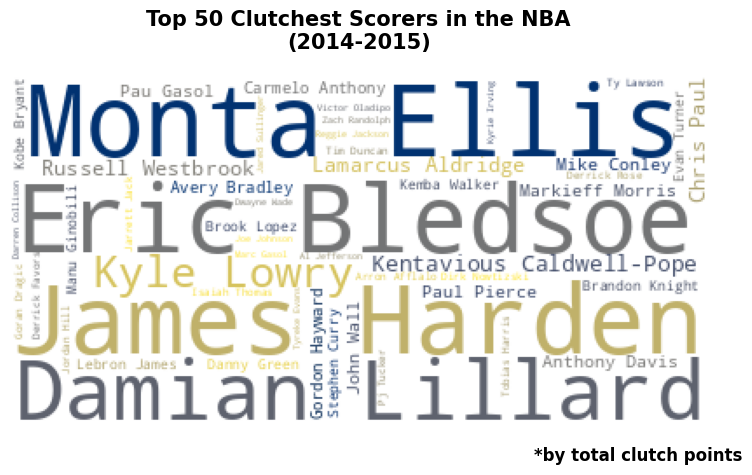

In [ ]:
# Creating a word cloud of the top 50 players in clutch points
clutch_dict = {}
for name in clutch_players.head(50).index:
    clutch_dict[name] = clutch_players.loc[name]['Clutch Points']
wordcloud = WordCloud(background_color='white', random_state=3, colormap='cividis_r').generate_from_frequencies(clutch_dict)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 50 Clutchest Scorers in the NBA\n(2014-2015)', pad=20, fontsize=15, weight='bold')
plt.text(300, 220, '*by total clutch points', weight='bold', fontsize=12)
plt.show()

**Findings:**

* The top scorer in the clutch during the 2014-2015 NBA regular season was Monta Ellis (73 total clutch points) of the Dallas Mavericks, highlighting his significant impact in high-pressure situations.

* Notably, 8 of the top 10 clutchest scorers were guards (point guards or shooting guards), which is explained by the fact that players in these positions handle the ball more frequently in late-game moments, creating scoring opportunities for themselves and/or their teammates.

**Note:**

Although other factors like shooting efficiency, playmaking, and defensive stops contribute to the evaluation of a player's overall performance in clutch situations, total scoring output was the main focus in this analysis since it is a straightforward and impactful indicator of a player's effectiveness in the clutch, directly capturing their ability to put points on the board when it counts the most.

# Michael

### Question 1: Who is the best defender in the NBA (from this dataset) based on blocks alone?

In [ ]:
!pip install colour
!pip install flexitext

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
from colour import Color
from flexitext import flexitext

In [ ]:
missed = nba_shots_data.loc[nba_shots_data['SHOT_RESULT'] == "missed"]
defender_summary = missed.sort_values('CLOSEST_DEFENDER', ascending=True).groupby('CLOSEST_DEFENDER')
lethal = defender_summary.count()['SHOT_RESULT'].rename("SUCCESSFUL DEFENSE").sort_values(ascending=False)
lethal.head(10)
lethal = lethal.to_frame().reset_index()[:10]

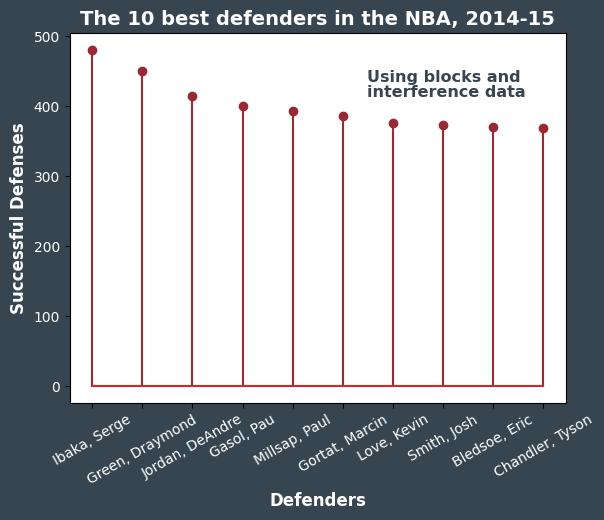

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor('#36454f')
col = Color("coral")
col.luminance = 0.3
col.blue += 0.2
plt.stem(lethal['CLOSEST_DEFENDER'],lethal['SUCCESSFUL DEFENSE'],col.get_hex_l())
plt.xticks(rotation=30, color = "white",fontsize=10)
plt.yticks(color = "white",fontsize=10)
plt.xlabel("Defenders",color="white",fontsize=12,fontweight="bold")
plt.ylabel("Successful Defenses",color="white",fontsize=12,fontweight="bold")
plt.title("The 10 best defenders in the NBA, 2014-15",color="white",fontweight = "bold",fontsize=14)
text = "<size:11.5,weight:bold,color:#36454f>Using blocks and \ninterference data</>"
flexitext(0.6, 0.9, text, va="top", ax=ax)
plt.show()

### Question 2: What is each player’s average number of dribbles for each shot?

In [ ]:
!pip install colour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from colour import Color
import numpy as np

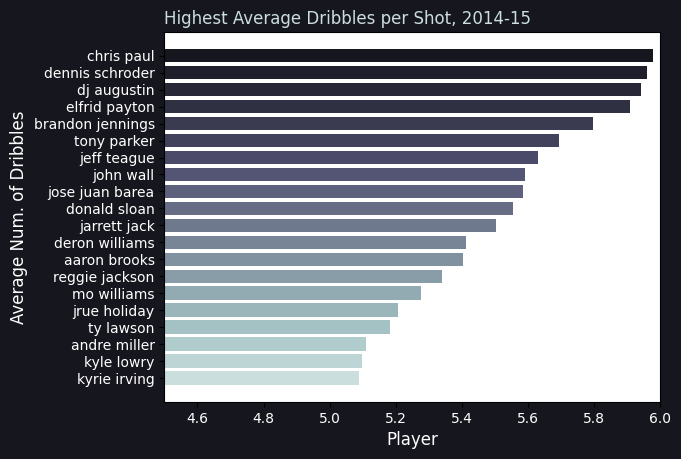

In [ ]:
md_data = nba_shots_data
dribbles = md_data.groupby('player_name')['DRIBBLES'].mean().sort_values(ascending=True)
dribbles = dribbles.to_frame().reset_index()[-20:]

cmap = plt.colormaps['bone']
colors = cmap(np.linspace(0.85, 0.1, 20))
fig, ax = plt.subplots()
fig.set_facecolor('#16161e')
plt.barh(dribbles['player_name'],dribbles['DRIBBLES'],color=colors)
plt.xlabel("Player",color="white",fontsize=12)
plt.ylabel("Average Num. of Dribbles",color="white",fontsize=12)
plt.yticks(color = "white")
plt.xticks(color = "white")
plt.xlim(4.5,6)
plt.title("Highest Average Dribbles per Shot, 2014-15",color="#cbdede",loc="left")

plt.show()

### Question 3: What were the most explosive games by attempted shots?

In [ ]:
import pandas as pd
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
md_data['GAME_ID'] = md_data['GAME_ID'].astype(str)
text2 = " ".join(item for item in md_data.GAME_ID)

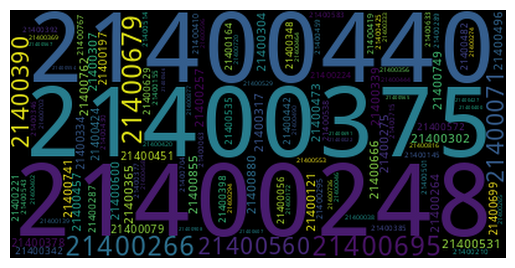

In [ ]:
frequencies={}
words=text2.split()

for word in words:
  if word in frequencies:
    frequencies[word]+=1
  else:
    frequencies[word]=1

cloud = WordCloud(colormap='viridis').generate_from_frequencies(frequencies)
plt.imshow(cloud, interpolation='lanczos')
plt.axis("off")
plt.show()


In [ ]:
md2 = md_data[md_data['GAME_ID'].isin(["21400248","21400375","21400266","21400695","21400440"])]
md2.groupby('GAME_ID').count()['SHOT_NUMBER'].sort_values(ascending=False)

,SHOT_NUMBER
GAME_ID,
21400248,198
21400375,194
21400440,193
21400266,191
21400695,190


#### **Above are the five games from the 2014-15 NBA season with the most attempted shots. These figures don't mean much, so here's context:**

**21400248** - Nov 30 - The Los Angeles Lakers beat the Toronto Raptors 129-122 in overtime, while Kobe Bryant had his 20th career triple-double.

**21400375** - Dec 17 - The Memphis Grizzlies overtook the San Antonio Spurs 117-116, though Spurs' Danny Green scored 25 points.

**21400440** - Dec 26 - The Denver Nuggets beat the Minnesota Timberwolves 106-102. While not a super high-scoring game, the high shot attempts figure is largely attributed to Nuggets' Kenneth Faried putting up 25 rebounds.

**21400266** - Dec 3 - The Brooklyn Nets end the San Antonio Spurs' winning streak with a 95-93 win. Nets' PF Mirza Teletovic scores a season-high 26 points.

**21400695** - Jan 29 - The Los Angeles Lakers ended their nine-game losing streak with a double-overtime 123-118 win over the Chicago Bulls. LAL Jordan Hill scored 26 points.